In [1]:
# ID5059 - Knowledge Discovery & Data Mining
# Coursework Assignment 1 - Individual
# Deadline: Friday 24th February 2023 (week 6), 9pm

In [1]:
################################################################################
###################### IMPORT LIBRARIES, DATA FRAME ############################
################################################################################

# Load libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zlib import crc32
# To split the training from testing sections
from sklearn.model_selection import StratifiedShuffleSplit
# Correlation matrix plots
from pandas.plotting import scatter_matrix
# Import to change the character variables to categorical
from sklearn.preprocessing import OrdinalEncoder
# Import to change the character variables to numerical
from sklearn.preprocessing import LabelEncoder
# This line runs on Jupyter Notebook only
#get_ipython().run_line_magic("matplotlib", "inline")

# Read the dataset from a file
# Specify type "string" for the "bed" and "dealer_zip" attributes to avoid errors interpreting them as numbers
cars = pd.read_csv("/Users/ernakuginyte/Documents/ID5059 Knowledge Discovery and Data Mining/Assignments/Project 1/data/small/used_cars_data_small_0.csv", \
    dtype = {"bed": "string", "dealer_zip": "string"})

                    vin back_legroom   bed bed_height bed_length  \
0     ZACNJABB5KPJ92081      35.1 in  <NA>        NaN        NaN   
1     SALCJ2FX1LH858117      38.1 in  <NA>        NaN        NaN   
2     JF1VA2M67G9829723      35.4 in  <NA>        NaN        NaN   
3     SALRR2RV0L2433391      37.6 in  <NA>        NaN        NaN   
4     SALCJ2FXXLH862327      38.1 in  <NA>        NaN        NaN   
...                 ...          ...   ...        ...        ...   
2755  3FA6P0HD4LR166836      38.3 in  <NA>        NaN        NaN   
2756  4JGDA5HB7HA816383      38.4 in  <NA>        NaN        NaN   
2757  1GTN1TEC7FZ903032           --  <NA>         --    78.9 in   
2758  3N1AB7AP9JY276352      37.4 in  <NA>        NaN        NaN   
2759  5NPEB4AC8BH173139      34.6 in  <NA>        NaN        NaN   

            body_type cabin         city  city_fuel_economy  \
0     SUV / Crossover   NaN      Bayamon                NaN   
1     SUV / Crossover   NaN     San Juan                N

array([[<AxesSubplot:title={'center':'city_fuel_economy'}>,
        <AxesSubplot:title={'center':'combine_fuel_economy'}>,
        <AxesSubplot:title={'center':'daysonmarket'}>,
        <AxesSubplot:title={'center':'engine_displacement'}>],
       [<AxesSubplot:title={'center':'highway_fuel_economy'}>,
        <AxesSubplot:title={'center':'horsepower'}>,
        <AxesSubplot:title={'center':'is_certified'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'listing_id'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'owner_count'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'savings_amount'}>,
        <AxesSubplot:title={'center':'seller_rating'}>,
        <AxesSubplot:title={'center':'sp_id'}>],
       [<AxesSubplot:title={'center':'vehicle_damage_category'}>,
        <AxesSubplot:title={'center':'year'}>, <Ax

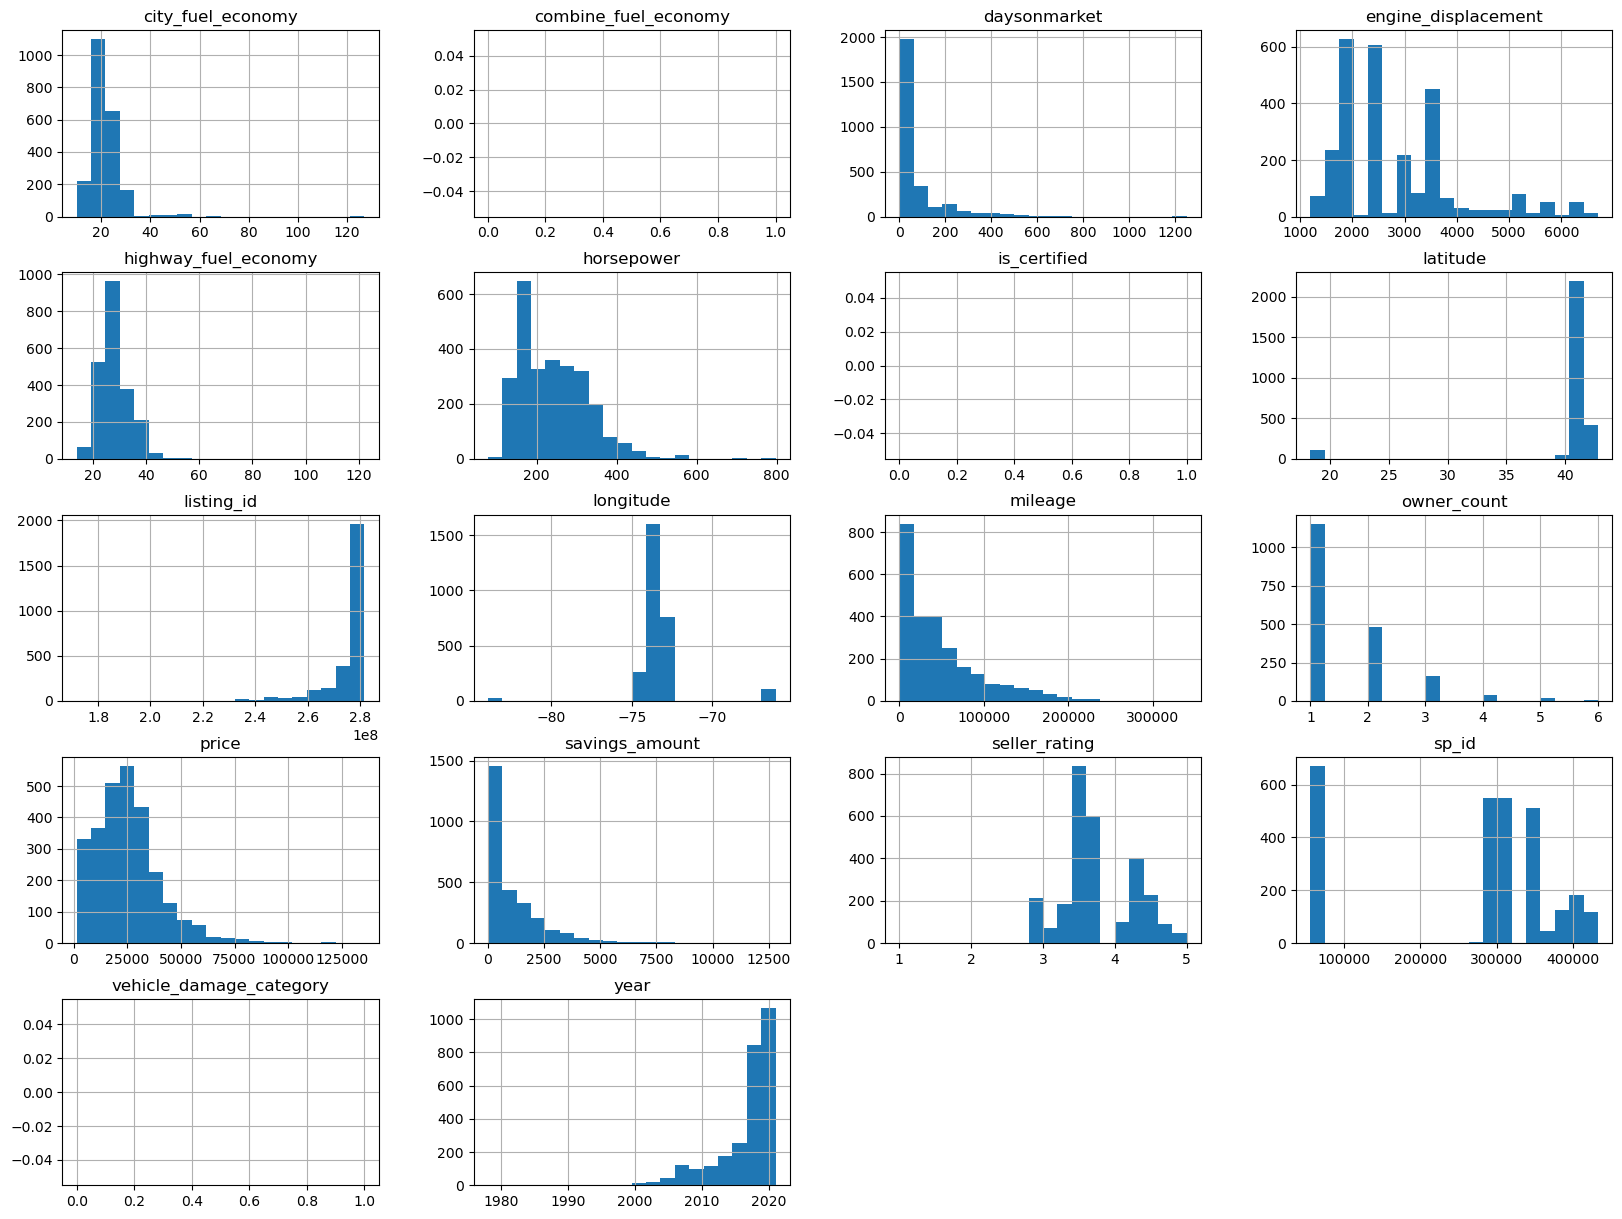

In [2]:
################################################################################
############################# EXPLORE THE DATA #################################
################################################################################

# Clear the maximum number of columns to be displayed, so that all will be visible
pd.set_option("display.max_columns", None)
# Check the basic statistics of the data
cars.describe()
# Display the data frame
print(cars)

# Explore numeric columns visually
cars.hist(bins = 20, figsize = (20, 15)) 

In [3]:
################################################################################
############################# DATA WRANGLING ###################################
################################################################################

################################ DUPLICATES ####################################

# Firstly, check for duplicates
print(cars.duplicated().sum()) 
# Drop duplicates
cars = cars.drop_duplicates()


# Add 0 to "owner_count" in missing values if "is_new" is True
cars.loc[(cars["is_new"] == True) & (cars["owner_count"].isnull()), "owner_count"] = 0

0


In [4]:
########################## DEAL WITH MISSING VALUES ############################

# Deal with the missing values.
# Check which columns have only missing values and drop them.
cars = cars.dropna(axis = 1, how = "all")

# Check which columns have some missing values.
# First find the number of missing values in each column.
na_columns = cars.isna().sum()
# Save the column names with missing values
cols_with_na = list(na_columns[na_columns > 0].index)
# Print the column names with number of missing values 
#    out of total number of rows in the data set
for col in cols_with_na:
    print(f"{col}: {na_columns[col]} missing values out of {cars.shape[0]}")

### clean_df - Cleans dataframe columns with missing data;
###            if more than 25% of rows are missing, the whole column will be dropped;
###            else, add median numeric values to the numeric data, string or object data won"t be modified.  
#   INPUT:
#              df - data frame with latent values.
#   OUTPUT:
#              df_cleaned - cleaned data frame.
def clean_df(df):
    
    # Firstly check if the input value is of correct type
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input argument incorrect, it should be a Data Frame! :)")
    # Check if the data frame has any missing values
    if not df.isnull().values.any():
        raise ValueError("Your data frame does not have any missing values, hooray! :)")    
        
    # Find the number of missing values in each column
    na_columns = df.isna().sum()

    # Calculate the percentage of missing values in each column
    na_columns_percent = na_columns / df.shape[0]

    # Get the names of the columns with more than 25% missing values
    cols_to_drop = list(na_columns_percent[na_columns_percent > 0.25].index)

    # Drop the columns with more than 25% missing values
    df_cleaned = df.drop(cols_to_drop, axis = 1)

    # Replace the missing values in the remaining columns with the median value
    # if the column is numeric, otherwise leave the values as is
    for col in df_cleaned.columns:
        # First check if the data type is numeric
        if df_cleaned[col].dtype in ["float64", "int64"]:
            # Fill the missing values with medians
            df_cleaned[col].fillna(df_cleaned[col].median(), inplace = True)
            
    # Return the cleaned data frame
    return df_cleaned

# Apply the function and save the cleaned data frame
cars = clean_df(df = cars)
# Print names of non-numeric columns with the number of missing values.
# Get the number of missing values in each non-numeric column
na_string_columns = cars.isna().sum()

# Get the names of non-numeric columns with missing values
cols_with_na = list(na_string_columns[na_string_columns > 0].index)

# Print the names of non-numeric columns with the number of missing values
for col in cols_with_na:
    print(f"{col}: {na_string_columns[col]} missing values out of {cars.shape[0]}")

back_legroom: 71 missing values out of 2760
bed: 2753 missing values out of 2760
bed_height: 2628 missing values out of 2760
bed_length: 2628 missing values out of 2760
body_type: 5 missing values out of 2760
cabin: 2748 missing values out of 2760
city_fuel_economy: 580 missing values out of 2760
description: 45 missing values out of 2760
engine_cylinders: 51 missing values out of 2760
engine_displacement: 76 missing values out of 2760
engine_type: 51 missing values out of 2760
fleet: 849 missing values out of 2760
frame_damaged: 849 missing values out of 2760
franchise_make: 1004 missing values out of 2760
front_legroom: 71 missing values out of 2760
fuel_tank_volume: 71 missing values out of 2760
fuel_type: 46 missing values out of 2760
has_accidents: 849 missing values out of 2760
height: 71 missing values out of 2760
highway_fuel_economy: 580 missing values out of 2760
horsepower: 76 missing values out of 2760
isCab: 849 missing values out of 2760
is_cpo: 2436 missing values out of

In [5]:
####################### ADD MEAN TO THE MISSING VALUES #########################

### fill_na_mean - Take away the " in", "in", " gal" measurement units from data set 
###                variables and converts it to a numeric object;
###                Fills latent variables with mean value.
#   INPUT:  
#                  variables_inches - names of variables that have " in" inches measurement;
#                                     also has some missing values.
#   OUTPUT: 
#                  data - cleaned data frame.
def fill_na_mean(data, vars):

    # Firstly check if the input value is of correct type
    # Check if data is a data frame?
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input argument incorrect, it should be a Data Frame! :)")
    # Check if the data frame has any missing values
    if not data.isnull().values.any():
        raise ValueError("Your data frame does not have any missing values, hooray! :)")
    # Check if the variables_inches vector is not empty
    if len(vars) == 0:
        raise ValueError("Variable list is empty! :)")

        # For each variable in the variables_inches list
    for variable in vars:

        # Check if the variable type is object
        if data[variable].dtype == object:
            # Remove the "in" and "gal" from the values
            data[variable] = data[variable].str.replace(" in", "").str.replace(" gal", "").\
                str.replace("in", "").str.replace("--", "")
            # Convert the string variables to numeric
            data[variable] = pd.to_numeric(data[variable], errors = "coerce")
        # Fill missing values with the mean
        data[variable] = data[variable].fillna(data[variable].mean())

    # Return the wrangled data frame
    return data

# Create a list of variables to fill the NAs with mean
variables_inches = ["back_legroom", "front_legroom", "height", "length", \
    "wheelbase", "width", "fuel_tank_volume"]

# Apply the fill_na_mean function and save the cleaned data frame
cars = fill_na_mean(data = cars, vars = variables_inches)

# The variables that have too many missing values or cannot be filled manually
#   as they are character variables; main_picture_url useless for this analysis
columns_to_drop = ["engine_cylinders", "fuel_type", "main_picture_url", "trimId", \
    "major_options", "power", "torque", "transmission_display", "trim_name", \
        "wheel_system", "wheel_system_display", "main_picture_url", "description", \
            "maximum_seating", "engine_type", "vin", "body_type"]
# Drop the unwanted variables
cars.drop(columns_to_drop, axis = 1, inplace = True)

########################## FILL OTHER MISSING VALUES ###########################

# Deal with missing values in listing_color and exterior_color variables.
# Replace the "UNKNOWN" values in listing_color with values from exterior_color.
cars.loc[cars["listing_color"] == "UNKNOWN", "listing_color"] = cars["exterior_color"]
# Replace the "None" values in exterior_color with values in listing_color
cars.loc[cars["exterior_color"] == "None", "exterior_color"] = cars["listing_color"]
# Delete rows where listing_color is UNKNOWN and exterior_color is None
cars = cars.loc[(cars["listing_color"] != "UNKNOWN") | (cars["exterior_color"].notna())]

# Calculate the mean of the "owner_count" column
mean_owner_count = np.nanmean(cars["owner_count"])
# Round the mean to the nearest integer
rounded_mean_owner_count = int(round(mean_owner_count))
# Replace missing values with the rounded mean
cars["owner_count"] = cars["owner_count"].fillna(rounded_mean_owner_count)

# Check which variables have missing values
print(cars.isnull().sum())

back_legroom             0
city                     0
city_fuel_economy        0
daysonmarket             0
dealer_zip               0
engine_displacement      0
exterior_color           0
franchise_dealer         0
front_legroom            0
fuel_tank_volume         0
height                   0
highway_fuel_economy     0
horsepower               0
interior_color           0
is_new                   0
latitude                 0
length                   0
listed_date              0
listing_color            0
listing_id               0
longitude                0
make_name                0
mileage                  0
model_name               0
owner_count              0
price                    0
savings_amount           0
seller_rating            0
sp_id                    0
sp_name                  0
transmission            36
wheelbase                0
width                    0
year                     0
dtype: int64


In [6]:
################################################################################
###################### DEAL WITH OTHER OBJECT VARIABLES ########################
################################################################################

################################ CATEGORICAL ###################################
# Convert categories from text to numbers
ordinal_encoder = OrdinalEncoder()
# Define which variables to change to categorical
char_variables = ["city", "franchise_dealer", \
    "is_new", "listing_color", "make_name", "model_name", \
        "sp_name", "transmission", "dealer_zip", "year"]
# Categorise variables
for variables in char_variables:
    cars[variables] = cars[variables].astype("category")

################################# NUMERICAL #####################################
# Encode character variables to numerical ones
# Create a label encoder object
encoder = LabelEncoder()
# Variables to convert to numerical ones
char_to_num_variables = ["exterior_color", "city", "interior_color", "make_name", "model_name", "sp_name"]
# Convert the character columns to numerical variables using transform function
for var in char_to_num_variables:
    encoder.fit(cars[var])
    cars[var+"_code"] = encoder.transform(cars[var].astype(str)) 

#################################### DATE ########################################
# Convert listed_date from object to Unix timestamp
cars["listed_date"] = pd.to_datetime(cars["listed_date"]).astype(int) // 10 ** 9

In [7]:
################################################################################
############################## ADD EXTRA VARIABLES #############################
################################################################################

# Add an extra variable savings_per_day
cars["savings_per_day"] = np.where(cars["daysonmarket"] == 0, 0, cars["savings_amount"] / cars["daysonmarket"])

back_legroom             float64
city                    category
city_fuel_economy        float64
daysonmarket               int64
dealer_zip              category
engine_displacement      float64
exterior_color            object
franchise_dealer        category
front_legroom            float64
fuel_tank_volume         float64
height                   float64
highway_fuel_economy     float64
horsepower               float64
interior_color            object
is_new                  category
latitude                 float64
length                   float64
listed_date                int64
listing_color           category
listing_id                 int64
longitude                float64
make_name               category
mileage                  float64
model_name              category
owner_count              float64
price                    float64
savings_amount             int64
seller_rating            float64
sp_id                      int64
sp_name                 category
transmissi

<AxesSubplot:>

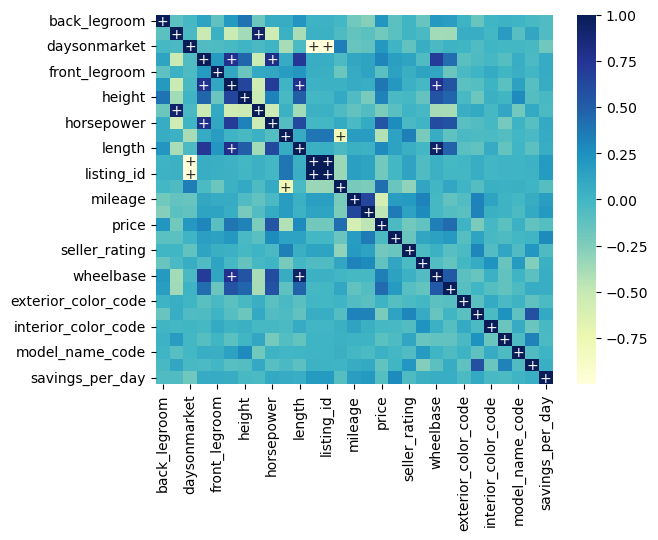

In [8]:
################################################################################
################################ CORRELATION ###################################
################################################################################

# Check which columns will be taken in for correlation function
print(cars.dtypes)
# Check for correlation in the data.
# Calculate the Pearson correlation coefficients for all covariates.
cor = cars.corr()
# Print the correlation coefficients
print(cor)

### custom_annotave - Custom annotating function.
#   INPUT:
#                     value - value of correlation to be highlighted;
#                     symbol - symbol to be used to highlight the values.
#   OUTPUT: 
#                     
def custom_annotate(value, symbol = "+"):
    if abs(value) >= 0.75:
        return symbol
    return ""

# Apply the custom annotating function to correlation data
annot = np.vectorize(custom_annotate)(cor)

# Plot the heatmap of correlations between variables
sns.heatmap(cor, annot = annot, fmt = "", cmap = "YlGnBu")

ValueError: Unknown format code 'd' for object of type 'float'

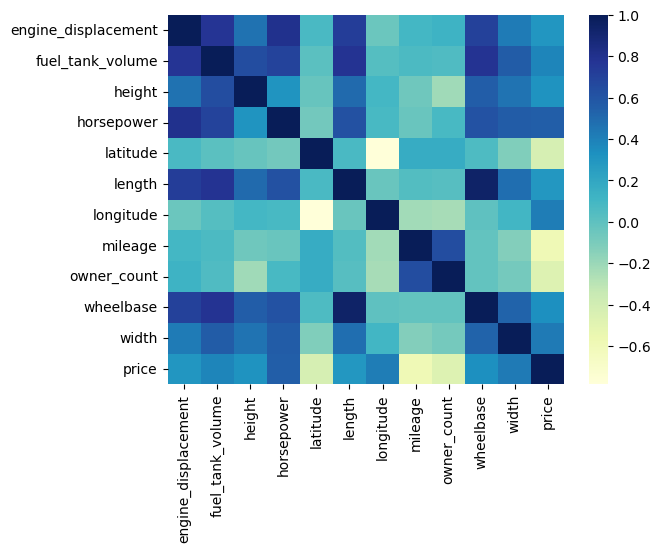

In [9]:
################################################################################
####################### SELECT VARIABLES FOR THE MODEL #########################
################################################################################

### important_variables - Function to select variables for the model.
#   INPUT:  
#                         corr_threshold - threshold of correlation with the price;
#                         data - data frame;
#   OUTPUT:
#                         cars_selected - updated data frame.
def important_variables(data = cars, corr_threshold = 0.5):
    # Get correlation matrix of all pairs of variables
    corr_matrix = data.corr()["price"]
    # Pre-set a variable to store selection
    selected_vars = []
    cars_selected = pd.DataFrame()
    # Select the variables with correlation greater than or equal to the threshold
    for col in corr_matrix.index:
        if abs(corr_matrix[col]) >= corr_threshold and col != "price":
            selected_vars.append(col)

    # Add the prediction variable "price" to the selected variables and create a new data frame
    selected_vars.append("price")
    cars_selected = data[selected_vars]
    # Return the new data frame
    return cars_selected

# Get the new data frame with selected variables
cars_selected = important_variables(data = cars, corr_threshold = 0.25)

# Get correlation matrix of all pairs of variables
corr_matrix = cars_selected.corr()
# Plot heatmap of correlation
sns.heatmap(corr_matrix, annot=True, fmt="d", cmap="YlGnBu")


/var/folders/cv/hjjyxpns6lsfcg_2_xmm_m0c0000gn/T/ipykernel_40776/1184889665.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_selected["price_categ"] = pd.qcut(cars_selected["price"], q = 5, labels = [1, 2, 3, 4, 5])


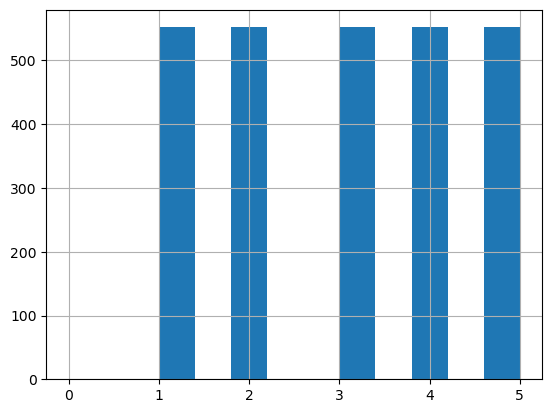

In [10]:
################################################################################
######################### TRAINING AND TEST SETS ###############################
################################################################################

# Check quantiles to then categorise the data in to 5 sections
cat = cars_selected["price"].describe()

# Create price_categ column to split the data into evenly distributed
#   training and testing sets
# Split the data by "price" column into normally distributed 5 bins
cars_selected["price_categ"] = pd.qcut(cars_selected["price"], q = 5, labels = [1, 2, 3, 4, 5])

# Plot the category values in a histogram to check if it makes sense
cars_selected["price_categ"].hist()

# Split the training and the testing sets
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 7) # 7 being the lucky number
for train_index, test_index in split.split(cars_selected, cars_selected["price_categ"]):
    strat_train_set = cars_selected.reset_index().loc[train_index]
    strat_test_set = cars_selected.reset_index().loc[test_index]

# Check if the categorical split makes sense
price_distribution = strat_test_set["price"].value_counts() / len(strat_test_set)
# Plot the histogram of the price distribution
price_distribution.hist()

# Drop the category column as it should not predict anything in the model
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("price_categ", axis = 1, inplace = True)

In [12]:
################################################################################
############################# FEATURE SCALING ##################################
################################################################################
# Check if the data has a lot of outliers to then decide if MINMAX or STANDARDISATION
# Create a boxplot for each numeric column 

# Select which variables to plot
numeric_cols = strat_train_set.select_dtypes(include="number").drop(columns=["price", "index"])

# Create a box plot for each numeric column
fig, axs = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(len(numeric_cols)*5, 5), sharey=True)
for i, col in enumerate(numeric_cols):
    axs[i].boxplot(strat_train_set[col])
    axs[i].set_title(col)

plt.tight_layout()

ValueError: Image size of 1104000x500 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1104000x500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1.104e+06x500 with 2208 Axes>

In [ ]:
# For price and mileage variables
numeric_cols2 = strat_train_set(columns=["price", "mileage"])
# Create a box plot for each numeric column
fig, axs = plt.subplots(nrows=1, ncols=len(numeric_cols2), figsize=(len(numeric_cols2)*5, 5), sharey=True)
for i, col in enumerate(numeric_cols2):
    axs[i].boxplot(strat_train_set[col])
    axs[i].set_title(col)

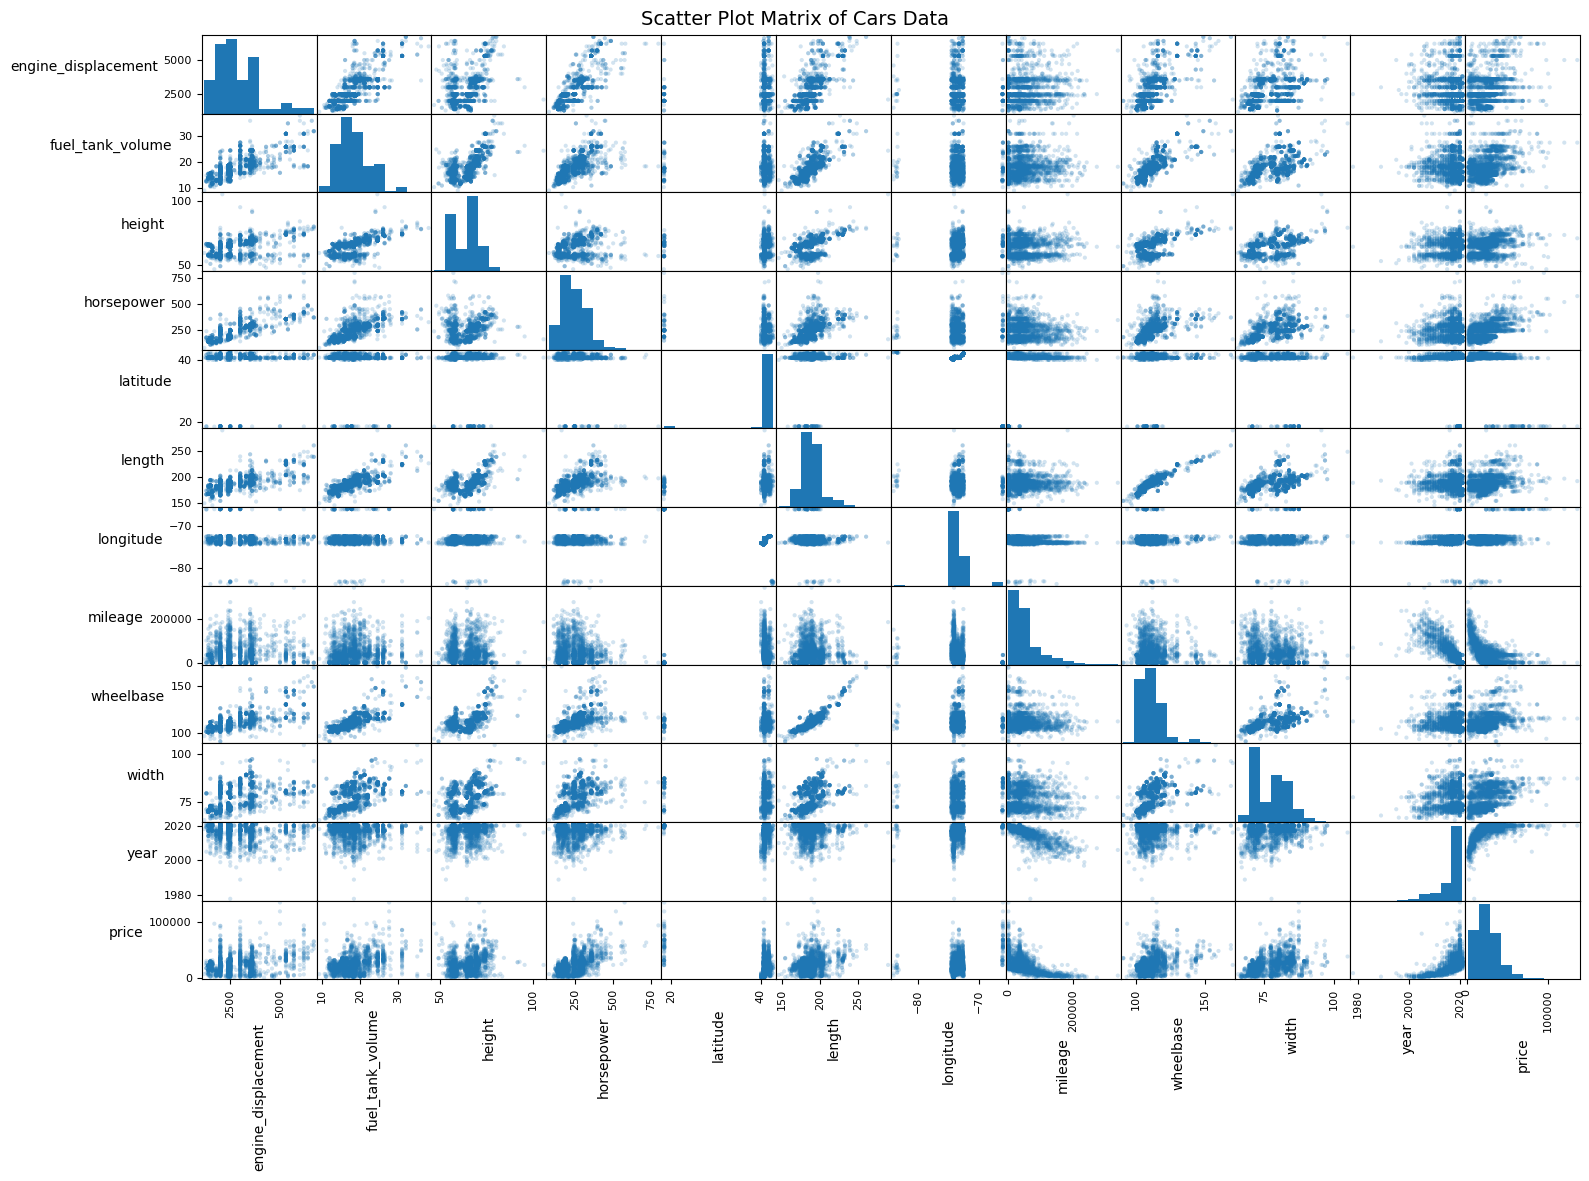

In [41]:
################################################################################
################# CORRELATION WITHIN THE TRAINING DATA SET #####################
################################################################################

# Explore the training data set visually
# First copy the data set.
cars_train = strat_train_set.copy()

# Check for correlation in the data.
# Use a scatter plot for the attributes, exclude column "index"
cols_to_plot = [col for col in cars_train.columns if col != "index"]
data_to_plot = cars_train[cols_to_plot]

# Plot the scatter matrix, excluding the "index" column
fig, axes = plt.subplots(nrows=len(data_to_plot.columns), ncols=len(data_to_plot.columns), figsize=(16, 12))
# Subtitle
plt.suptitle("Scatter Plot Matrix of Cars Data", fontsize=14)
pd.plotting.scatter_matrix(data_to_plot, alpha=0.2, ax=axes)
# Rotate the x-axis labels vertically and y-axis labels horizontally
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
# Set layout
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)



In [31]:
################################################################################
###################### TRANSFORM THE TRAINING DATA SET #########################
################################################################################
cars_train.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2204 entries, 86 to 1715
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2204 non-null   int64  
 1   engine_displacement  2204 non-null   float64
 2   fuel_tank_volume     2204 non-null   float64
 3   height               2204 non-null   float64
 4   horsepower           2204 non-null   float64
 5   latitude             2204 non-null   float64
 6   length               2204 non-null   float64
 7   longitude            2204 non-null   float64
 8   mileage              2204 non-null   float64
 9   wheelbase            2204 non-null   float64
 10  width                2204 non-null   float64
 11  year                 2204 non-null   int64  
 12  price                2204 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 241.1 KB
